# Spacial Analysis of System Calls Made By Docker Build

- Analysis of building the `syso` docker image

## Conditions
- ASLR disabled with `sysctl kernel.randomize_va_space=0`
- Run on `morningrise` with the following command
- Run from `~/syso`
```shell
make && sudo ./bin/syso /snap/bin/docker build . -t syso 2>./log/docker.log
```

The command
- Builds the project
- Builds the container to run `syso`, monitored by syso.

## `syso` limitations
- Short lived processes sometimes exist to briefly for their memory map to be processed by `syso`. This results in a library value of `"failed"`.
- No ringbuffer overwrite detection (todo asap)

In [34]:
import pandas as pd

df = pd.read_json("../stats/docker-stats.json")
syscalls_df = pd.read_csv("./syscalls.csv")

df.head()

,syscall_nr,library,pid,ppid,timestamp
0,13,unmapped,3458039,3457990,2101-08-25 21:01:39.082166
1,13,unmapped,3458039,3457990,2101-08-25 21:01:39.090223
2,13,unmapped,3458039,3457990,2101-08-25 21:01:39.091888
3,13,unmapped,3458039,3457990,2101-08-25 21:01:39.093156
4,13,unmapped,3458039,3457990,2101-08-25 21:01:39.094349


## How many shared libraries are involved?

In [23]:
counts_by_lib_df = df.groupby('library').size().reset_index(name='count')

total_invocs = counts_by_lib_df["count"].sum()

counts_by_lib_df["% invocations"] = (counts_by_lib_df["count"] / total_invocs) * 100

counts_by_lib_df.head(20)

,library,count,% invocations
0,/snap/docker/2932/bin/docker,1123,4.779944
1,/snap/docker/2932/usr/libexec/docker/cli-plugi...,14179,60.351579
2,/usr/bin/snap,972,4.137227
3,/usr/lib/snapd/snap-exec,607,2.583638
4,/usr/lib/x86_64-linux-gnu/ld-linux-x86-64.so.2,72,0.306461
5,/usr/lib/x86_64-linux-gnu/libc.so.6,1016,4.324508
6,FAILED,5463,23.252745
7,unmapped,62,0.263897


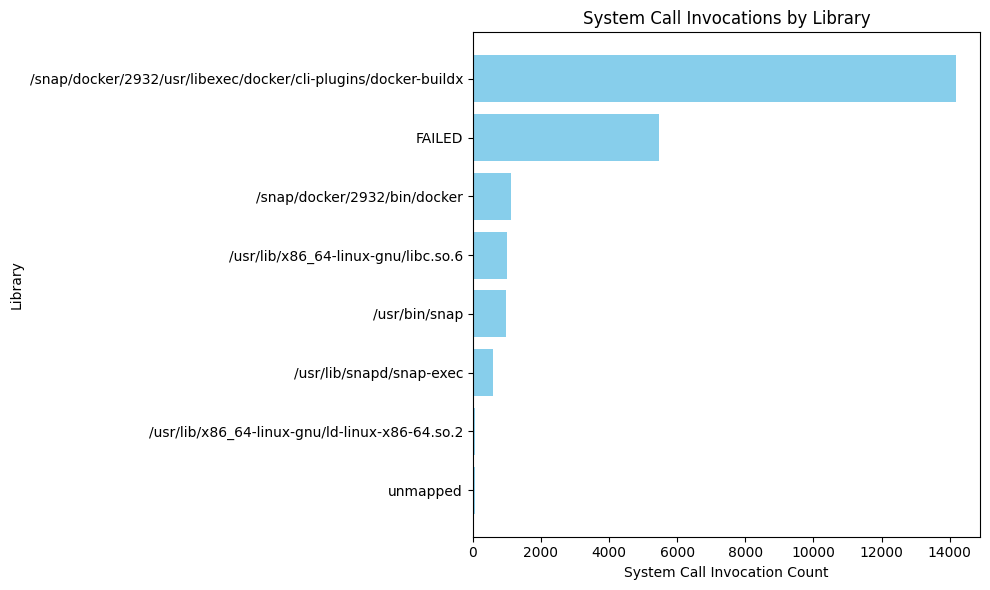

In [28]:
import matplotlib.pyplot as plt

# Sort the DataFrame by 'count' in descending order
counts_by_lib_df = counts_by_lib_df.sort_values('count', ascending=True)

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(counts_by_lib_df['library'], counts_by_lib_df['count'], color='skyblue')

# Add labels and title
plt.xlabel('System Call Invocation Count')
plt.ylabel('Library')
plt.title('System Call Invocations by Library')

# Show the plot
plt.tight_layout()
plt.show()


### Analysis: _How Many Shared Libraries are Involved_
- Extremely high failure rate (23.3%) from this run: bad! Will require investigating
- Other than that, majority came from `/snap/docker/2932/usr/libexec/cli-plugins/docker/buildx`
- 4% of calls came from libc.

## Where Did Specific Types of Syscall Come From

In [45]:
# Step 1: Group by syscall_nr and library to count invocations
syscall_lib_counts = df.groupby(['syscall_nr', 'library']).size().reset_index(name='invocations')

# Step 2: Calculate total invocations for each syscall_nr
syscall_totals = syscall_lib_counts.groupby('syscall_nr')['invocations'].transform('sum')

# Step 3: Calculate the percentage of invocations per library for each syscall
syscall_lib_counts['percentage'] = (syscall_lib_counts['invocations'] / syscall_totals) * 100

# Step 4: Optionally, sort the data for better visualization (optional)
syscall_lib_counts = syscall_lib_counts.sort_values(by=['syscall_nr', 'invocations'], ascending=[True, False])

# Display the result
syscall_lib_counts.head()

,syscall_nr,library,invocations,percentage
1,0,/snap/docker/2932/usr/libexec/docker/cli-plugi...,873,78.933092
6,0,FAILED,152,13.743219
5,0,/usr/lib/x86_64-linux-gnu/libc.so.6,32,2.893309
2,0,/usr/bin/snap,19,1.717902
0,0,/snap/docker/2932/bin/docker,17,1.537071


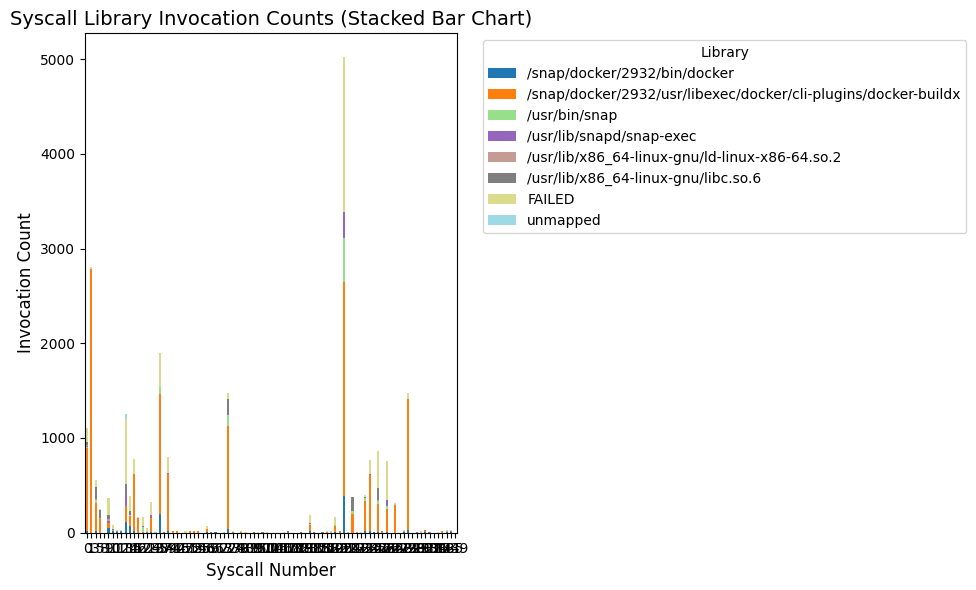

In [47]:
df_pivot = syscall_lib_counts.pivot(index='syscall_nr', columns='library', values='invocations').fillna(0)

# Plotting the stacked bar chart
ax = df_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

# Customizing the chart
plt.title('Syscall Library Invocation Counts (Stacked Bar Chart)', fontsize=14)
plt.xlabel('Syscall Number', fontsize=12)
plt.ylabel('Invocation Count', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Library", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

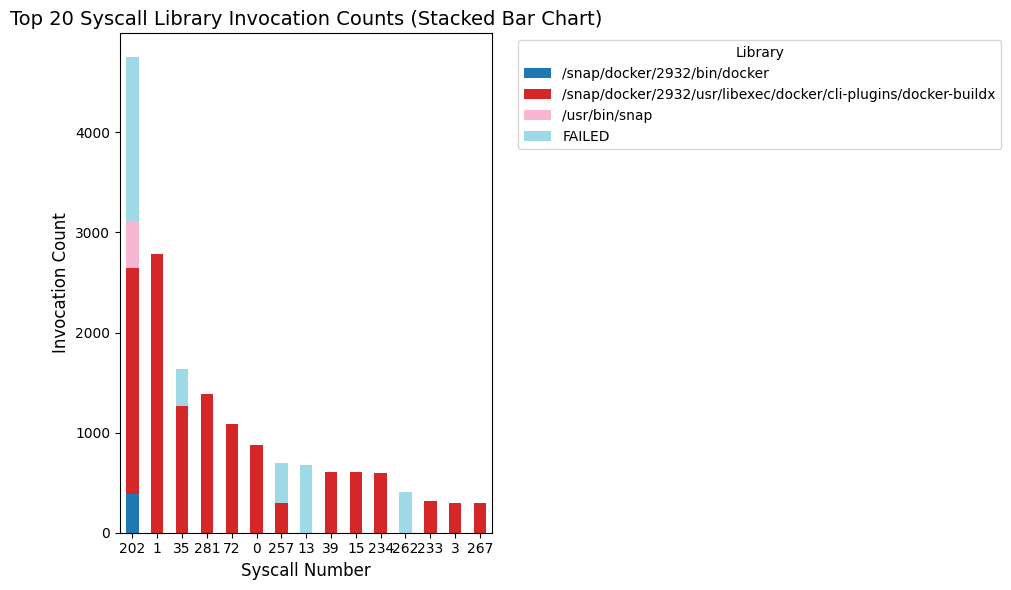

In [54]:
# Sort the dataframe by invocations to get the top 20 syscalls
top_syscalls = syscall_lib_counts.sort_values(by='invocations', ascending=False).head(20)

# Calculate the total invocations for each syscall (sum of all libraries for that syscall)
top_syscalls_total = top_syscalls.groupby('syscall_nr')['invocations'].sum()

# Sort the syscalls by the total invocation count in descending order
sorted_syscalls = top_syscalls_total.sort_values(ascending=False).index

# Filter the dataframe to keep only the sorted syscalls (based on the total invocation count)
top_syscalls_sorted = top_syscalls[top_syscalls['syscall_nr'].isin(sorted_syscalls)]

# Pivot the data to get libraries as columns and syscall_nr as rows
df_pivot = top_syscalls_sorted.pivot(index='syscall_nr', columns='library', values='invocations').fillna(0)

# Reorder the rows in df_pivot to reflect the sorted order of syscalls
df_pivot = df_pivot.loc[sorted_syscalls]

# Plotting the stacked bar chart
ax = df_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

# Customizing the chart
plt.title('Top 20 Syscall Library Invocation Counts (Stacked Bar Chart)', fontsize=14)
plt.xlabel('Syscall Number', fontsize=12)
plt.ylabel('Invocation Count', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Library", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()